In [1]:
from pathlib import Path
from IPython.display import Image as IPImage

from matplotlib import pylab as plt
from matplotlib import gridspec
import matplotlib.cm as cm

import seaborn as sns
sns.set(font_scale=1.2)

from nmtpytorch.translator import Translator
from nmtpytorch.utils.data import to_var

import numpy as np
import torch

import tqdm

from skimage import transform

In [2]:
def standardize(x, mode=None):
    return (x - x.min()) / (x.max() - x.min())

def torch2ndarray(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = np.transpose(x.cpu().numpy(), (1, 2, 0))
    return np.clip(img * std[None, None] + mean[None, None], a_min=0, a_max=1)

In [3]:
def plot(model, data, idx, smooth=True, transpose=False, sigma=20, maxnorm=True):#sample, image, smooth=True):
    # Unpack
    src, hyp, img, ta, ia = data[idx]
    
    # Textual attention as matrix
    tas = np.stack(ta).T
    
    src = model.src_vocab.idxs_to_sent(src, debug=True).split(' ')
    hyp = model.trg_vocab.idxs_to_sent(hyp, debug=True).split(' ')

    # 6 for 6x6 or 14 for 14x14, etc.
    img_att_dim = int(np.sqrt(ia[0].shape[0]))
    spat_dim = (img_att_dim, img_att_dim)
    ias = np.stack(ia).reshape((-1, img_att_dim, img_att_dim))
    if transpose:
        ias = np.transpose(ias, (0, 2, 1))
    if smooth:
        alpha = [transform.pyramid_expand(
            ias[ii], upscale=img.shape[0]/img_att_dim, sigma=sigma) for ii in range(ias.shape[0])]
    else:
        alpha = [transform.resize(
            ias[ii], [img.shape[0], img.shape[1]], mode='reflect') for ii in range(ias.shape[0])]
        
    kwargs = {}
    if maxnorm:
        kwargs['vmax'] = max([a.max() for a in alpha])

    # Compute wxh for placing image attention
    n_words = len(hyp) + 1
    w = int(np.round(np.sqrt(n_words)))
    h = 5
    w = n_words // h + int(n_words % h > 0)
      
    # Create a grid
    grid = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

    # Get subplot
    fig = plt.figure(figsize=(16, 8))
    ax1 = plt.subplot(grid[0])
    
    # Plot text attention
    sns.heatmap(tas, xticklabels=hyp, yticklabels=src, cmap='Greys',
                square=True, linewidths=0, cbar=False, ax=ax1)
    plt.yticks(rotation=0)

    inner_grid = gridspec.GridSpecFromSubplotSpec(w, h, grid[1], wspace=0.05, hspace=0.1)
    ax = plt.subplot(inner_grid[0])
    # Show image
    ax.imshow(img)
    ax.set_axis_off()
    # 1->black, 0->white
    plt.set_cmap(cm.jet)
    
    for ii in range(ias.shape[0]):
        ax = plt.subplot(inner_grid[ii + 1])
        ax.text(0, -10, hyp[ii], color='black', backgroundcolor='#ffffff', fontsize=12)
        # Show image
        ax.imshow(img)
        ax.imshow(alpha[ii], alpha=0.6, **kwargs)
        ax.set_axis_off()
        
    plt.figure()
    plt.imshow(ias.mean(0))
    plt.axis('off')
    plt.colorbar()
    return tas, ias

In [8]:
def process(modeltype, split='test_2017_flickr'):
    root = Path('/lium/raid01_a/caglayan/models/MMT18/en-de/bpe10k') / modeltype
    model_file = sorted(list(root.glob('*.best.meteor_*ckpt')),
        key=lambda x: float(x.name.split('best.meteor_')[-1].replace('.ckpt', '')))[-1]

    translator = Translator(models=[model_file], splits=split,
                            source=None, disable_filters=False)
    model = translator.instances[0]
    model.load_data(translator.splits[0])

    # Load and decode
    loader = model.datasets[translator.splits[0]].get_loader_args(batch_size=96, inference=True)
    data = []
    for batch_ in tqdm.tqdm(loader, unit='batch'):
        batch = to_var(batch_, volatile=True)
        img_att = [[] for i in range(batch.size)]
        txt_att = [[] for i in range(batch.size)]
        hyps = [[] for i in range(batch.size)]
        srcs = batch[model.sl].data.cpu().t().tolist()
        imgs = batch['image'].data.cpu()
        fini = torch.zeros(batch.size).long().cuda()
        ctx_dict = model.encode(batch)
        # Get initial hidden state
        h_t = model.dec.f_init(ctx_dict)

        y_t = model.get_bos(batch.size).cuda()

        # Iterate for 100 timesteps
        for t in range(100):
            y_t = to_var(y_t, volatile=True)
            logp, h_t = model.dec.f_next(ctx_dict, model.dec.emb(y_t), h_t)
            tatt = model.dec.txt_alpha_t.cpu().data.clone().numpy()
            iatt = model.dec.img_alpha_t.cpu().data.clone().numpy()
            top_scores, y_t = logp.data.topk(1, largest=True)
            hyp = y_t.cpu().numpy().tolist()
            for idx, w in enumerate(hyp):
                if 2 not in hyps[idx]:
                    hyps[idx].append(w[0])
                    txt_att[idx].append(tatt[:, idx])
                    img_att[idx].append(iatt[:, idx])

            fini = fini | y_t.eq(2).squeeze().long()
            if fini.sum() == batch.size:
                break

        for s, h, ta, ia, img in zip(srcs, hyps, txt_att, img_att, imgs):
            data.append((s, h, torch2ndarray(img), ta, ia))

    # Put into correct order
    data = [data[i] for i, j in sorted(
        enumerate(loader.batch_sampler.orig_idxs), key=lambda k: k[1])]
    # Sort by increasing length
    data = sorted(data, key=lambda x: len(x[0]))
    
    return data, model

In [9]:
res4f, m1 = process('amnmtv2-res4f')
res4f_l2, m2 = process('amnmtv2-res4f-l2norm-feats')

-- models -> [PosixPath('/lium/raid01_a/caglayan/models/MMT18/en-de/bpe10k/amnmtv2-res4f/dec256-emb128-enc256-adam_4e-04-l2_1e-05-do_ctx_0.5-do_emb_0.4-do_out_0.5-rf7777-val029.best.meteor_57.461.ckpt')]
-- splits -> test_2017_flickr
-- source -> None
-- disable_filters -> False
Loading CNN
ImageEncoder(cnn_type=resnet50, pretrained=True)
 - conv1(requires_grad=False)
 - bn1(requires_grad=False)
 - relu
 - maxpool
 - res2c_relu(requires_grad=False)
 - res3d_relu(requires_grad=False)
 - res4f_relu(requires_grad=False)
 Output shape: 1024x14x14
 # parameters: 8.54M (0.00 learnable)

Post-processing filters enabled.
Will translate "test_2017_flickr"
1000sents [00:00, 33289.18sents/s]
1000sents [00:00, 26773.12sents/s]
MultiParallelDataset - (2 sources / 1 targets)
  Sources:
    TextDataset (1000 sentences)
     test_2017_flickr.lc.norm.tok.bpe.en

    ImageFolderDataset(replicate=1) (1000 samples)
     /disk2/tmp/caglayan/mmt2018/data/images/test_2017_flickr
     Transforms: Compose(
   

In [95]:
# Good samples: 464, 615, 7, 103
idx = np.random.choice(len(res4f), size=1)[0]
print(idx)

954


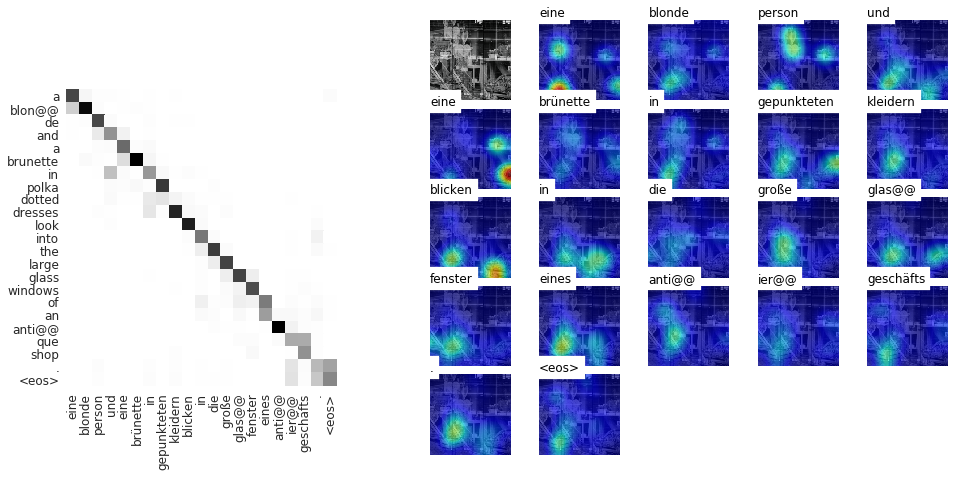

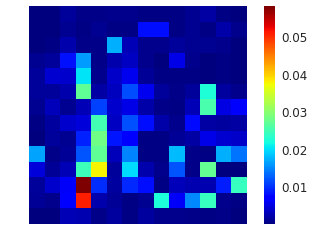

In [96]:
tas, ias = plot(m1, res4f, idx, smooth=True, maxnorm=True)

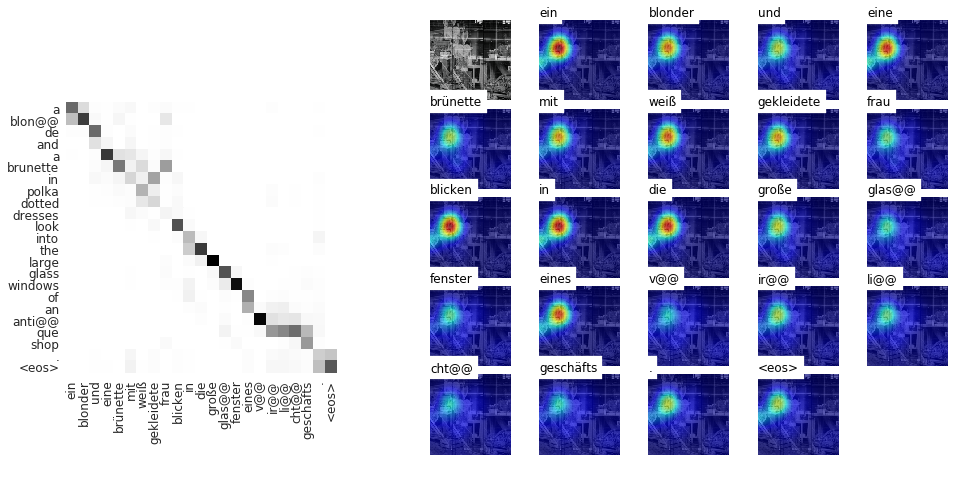

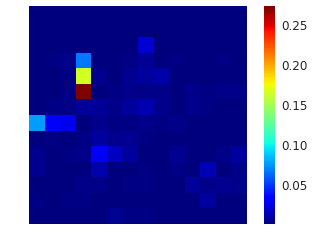

In [97]:
tas, ias = plot(m2, res4f_l2, idx, smooth=True, maxnorm=True)